# Seattle Airbnb Review EDA

This EDA is based on Seattle Airbnb dataset posted in Kaggle. <br>
In summary, 4 questions centered at Airbnb Reviews are targetted to be answered: <br>
- Which neighborhood has the best reivew rating (on average)?
- Is there a linear relationship between price and review rating?
- In which season most reviews are left?
- What features turn to drive a good review of a listing?
- What's the difference in review between top 25 percent and bottom 25 percent review?

**Dataset:**
- listings: all listings and features of a listing - main dataset of this analysis
- calendar: irrelevant to review - not used
- reviews: descriptive reviews with time series - less used

## Data collection

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from wordcloud import WordCloud, STOPWORDS
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

%matplotlib inline

In [2]:
plt.style.use('ggplot')
sb.set_style('white')

In [3]:
import os
os.listdir()

['.git',
 '.ipynb_checkpoints',
 'airbnb',
 'Airbnb-Copy1.ipynb',
 'Airbnb.ipynb',
 'calendar.csv',
 'listings.csv',
 'reviews.csv']

In [4]:
df_cal = pd.read_csv("calendar.csv")
df_lst = pd.read_csv("listings.csv")
df_rev = pd.read_csv("reviews.csv")

In [5]:
df_lst.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [6]:
df_lst.shape, df_cal.shape, df_rev.shape

((3818, 92), (1393570, 4), (84849, 6))

## Data quality

In [7]:
# if any duplicated records in listing dataset
sum(df_lst['id'].duplicated())

0

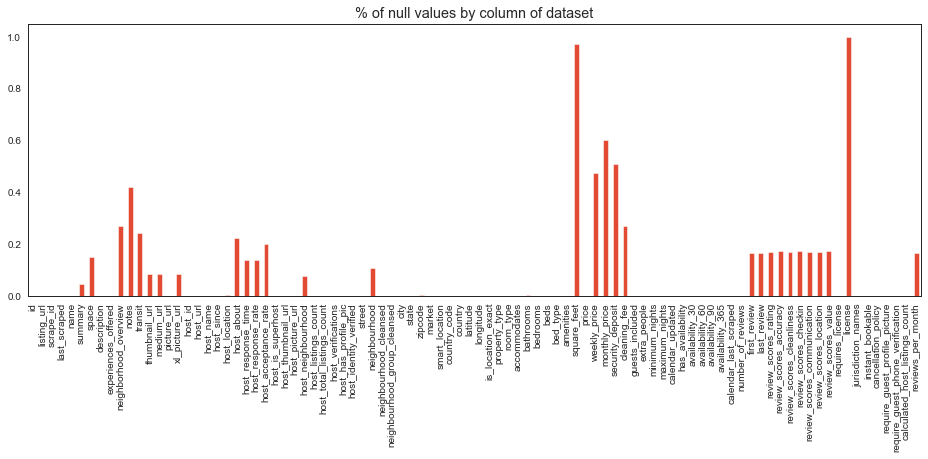

In [8]:
def null_cols_plot(df):
    """
    This function is to check and visulize percent of null data in each column,
    return a bar plot
    """
    (np.sum(df.isnull())/df.shape[0]).plot(kind = 'bar', figsize = (16,5))
    plt.title('% of null values by column of dataset')
    

null_cols_plot(df = df_lst)

In [9]:
# drop a column without any no_null values and a column whose majority is null
df_lst_new = df_lst.drop(['license', 'square_feet'], axis = 1)

In [10]:
# First drop some columns that will not be used e.g. url
def drop_urls(df):
    """
    This function drop all columns containing url,
    return a new dataframe
    """
    for col in df.columns:
        if 'url' in col:
            df_new = df.drop(col, axis = 1, inplace = True)
    
    return df_new

drop_urls(df_lst_new)

In [11]:
# drop single value columns in df_lst
single_value_cols = [col for col in df_lst_new.columns if len(df_lst_new[col].value_counts()) == 1]

df_lst_new = df_lst_new.drop(single_value_cols, axis = 1)

# 1 left due to case sensitive
df_lst_new = df_lst_new.drop('state', axis = 1)

In [12]:
# drop descriptive variables, location variables, other irrelevant variables and features with majority the same
descrip_lst = ['name', 'summary','space','description','neighborhood_overview',
               'notes','transit','host_id','host_name','host_name', 'host_location', 
               'host_about','street', 'neighbourhood', 'neighbourhood_cleansed', 'city', 
               'zipcode', 'latitude','longitude', 'host_neighbourhood', 'smart_location', 
               'host_response_rate', 'host_acceptance_rate', 'is_location_exact', 
               'first_review', 'last_review', 'host_since','calendar_updated']

df_new = df_lst_new.drop(descrip_lst, axis = 1)

In [13]:
# host total listings and host listings are duplicates
sum(df_new['host_total_listings_count'] == df_new['host_listings_count'])

3816

In [14]:
sum(df_new['calculated_host_listings_count'] == df_new['host_listings_count'])

3189

In [15]:
cat_cols = df_new.select_dtypes(include = 'object')
for cat_col in cat_cols:
    print(df_new[cat_col].value_counts()/df_new.shape[0])

within an hour        0.443164
within a few hours    0.253536
within a day          0.156365
a few days or more    0.009953
Name: host_response_time, dtype: float64
f    0.795705
t    0.203772
Name: host_is_superhost, dtype: float64
['email', 'phone', 'facebook', 'reviews', 'kba']                                 0.155841
['email', 'phone', 'reviews', 'kba']                                             0.114196
['email', 'phone', 'reviews']                                                    0.086171
['email', 'phone', 'facebook', 'reviews', 'jumio']                               0.084337
['email', 'phone', 'reviews', 'jumio']                                           0.050812
                                                                                   ...   
['email', 'phone', 'facebook', 'google', 'linkedin', 'kba']                      0.000262
['email', 'phone', 'linkedin', 'reviews', 'manual_offline', 'sent_id', 'kba']    0.000262
['email', 'phone', 'facebook', 'reviews', 'manu

In [16]:
# some columns have a single values over 90%, will drop these columns
drop_lst = ['host_has_profile_pic', 'bed_type', 'require_guest_profile_picture', 'require_guest_phone_verification']
df_new = df_new.drop(drop_lst, axis = 1)

In [17]:
# drop host listings count
df_new.drop(['host_listings_count', 'host_total_listings_count', 'calculated_host_listings_count'], axis = 1, inplace = True)

In [18]:
# drop price with around 0.5 empty - weekly price and monthly price
df_new.drop(['monthly_price', 'weekly_price'], axis = 1, inplace = True)

In [19]:
# imputing bathroom, bedrooms, beds with mode
df_new['bathrooms'] = df_new['bathrooms'].fillna(df_new['bathrooms'].mode()[0])
df_new['bedrooms'] = df_new['bedrooms'].fillna(df_new['bedrooms'].mode()[0])
df_new['beds'].fillna(df_new['beds'].mode()[0], inplace = True)

In [20]:
# imputing property_type
df_new['property_type'].fillna('Other', inplace = True)

In [21]:
# drop review per month, it's highly correlated to review history and number of reviews
df_new.drop('reviews_per_month', axis = 1, inplace = True)

In [22]:
# drop rows with target values as null
no_review_index = df_new[df_new['number_of_reviews'] == 0].index
df_new.drop(index = no_review_index, axis = 0, inplace = True)

In [23]:
# fillna for security deposite and cleaning_fee
df_new[['security_deposit', 'cleaning_fee']] = df_new[['security_deposit', 'cleaning_fee']].fillna(0)

In [24]:
# change type of price
price_cols = ['price', 'extra_people','security_deposit', 'cleaning_fee']
df_new[price_cols] = df_new[price_cols].replace("[\$,]", "", regex = True).astype('float')
df_new[price_cols].head()

,price,extra_people,security_deposit,cleaning_fee
0,85.0,5.0,0.0,0.0
1,150.0,0.0,100.0,40.0
2,975.0,25.0,1000.0,300.0
4,450.0,15.0,700.0,125.0
5,120.0,30.0,0.0,40.0


In [25]:
# drop other review scores due to collinearity
df_new.drop(['review_scores_accuracy', 'review_scores_cleanliness', 
        'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
        'review_scores_value'], axis = 1, inplace = True)

In [26]:
# check the rest of columns with blank values
df_new['host_response_time'].value_counts()/df_new.shape[0]

within an hour        0.478220
within a few hours    0.263240
within a day          0.149170
a few days or more    0.009088
Name: host_response_time, dtype: float64

In [27]:
# fill with mode
df_new['host_response_time'].fillna('other', axis = 0, inplace = True)

In [28]:
# drop null in review_scores_rating
df_new = df_new.dropna(axis = 0, subset = ['review_scores_rating'])

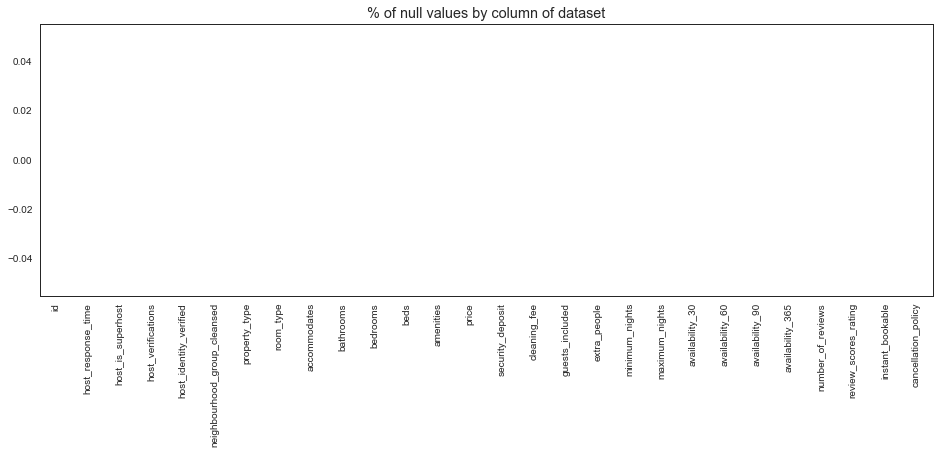

In [29]:
null_cols_plot(df = df_new)

> Now the dataset has all been cleaned up.

## Feature engineering

> In cleaned dataset, there are some features can't be used directly by model, in this part some of the features will be amended in order to create new features.

In [30]:
# adjust verification ways to number of verification ways
df_new['host_verifications_num'] = df_new['host_verifications'].apply(lambda x: len(x.split(',')))
df_new.drop('host_verifications', axis = 1, inplace = True)

In [31]:
# adjust verification ways to number of verification ways
df_new['amentities_num'] = df_new['amenities'].apply(lambda x: len(x.split(',')))
df_new.drop('amenities', axis = 1, inplace = True)

In [32]:
# use length of comments as a feature rather than text
comments_list = ['summary', 'space', 'description', 'neighborhood_overview', 'notes']

def comments_preparation(df, col):
    """
    This function remove stopwords of comments and count their length as a new feature,
    return a list of counted length
    """
    col_length = []
    for i in np.arange(0, df.shape[0]):
        if len(df[col].iloc[i]) != 0:
            # remove punctuation
            text_string = df[col].iloc[i].translate(str.maketrans("", "", string.punctuation)).lower()
            # tokenize comments
            text_tokens = word_tokenize(text_string)
            # remove stopwords in comments
            tokens_without_sw = [word for word in text_tokens if not word in stopwords.words('english')]
            # count length
            col_length.append(len(tokens_without_sw))

        else:
            col_length.append(0)

    return col_length

In [33]:
# adjust data type and prepare data
df_lst[comments_list] = df_lst[comments_list].astype('str')

# comments will be summary, space, description, neighborhood_overview, notes that everything hosts can leave
df_lst['comments'] = df_lst['summary'] + df_lst['space'] + df_lst['description'] + df_lst['neighborhood_overview'] + df_lst['notes']

# comments length preparation and merge new feature back to main dataset
comments_len = comments_preparation(df_lst, 'comments')
df_lst['comments_len'] = comments_len
df_new = df_new.merge(df_lst[['id', 'comments_len']], how = 'left', left_on = 'id', right_on = 'id')

## Distribution of target - review scores rating

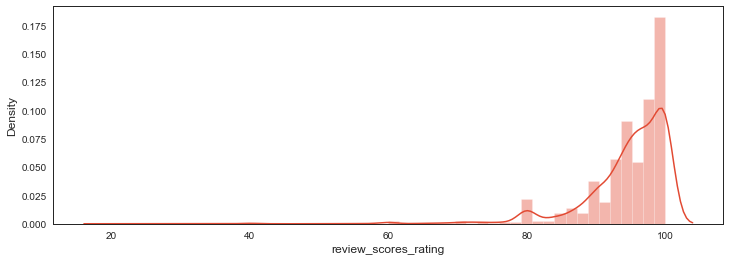

In [34]:
plt.figure(figsize = (12,4))
sb.distplot(df_new['review_scores_rating']);

> Target review scores rating is a lot left skewed, a lot is between 90 and 100.

## 1. Which neighborhood has the best reivew rating (on average)?

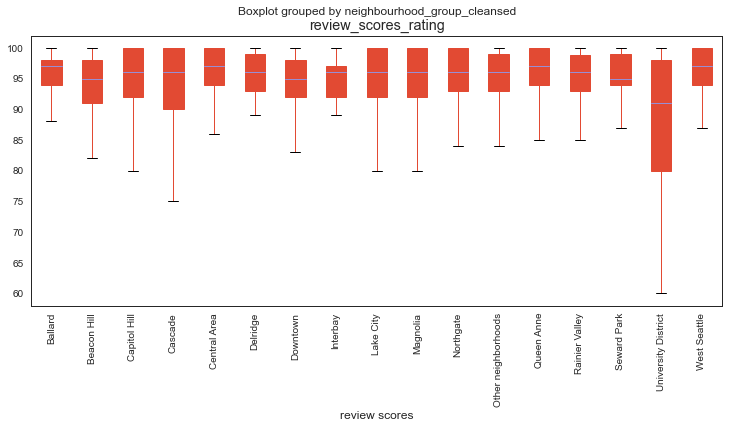

In [35]:
# review scores by neighborhood visualize
df_new.boxplot(column = 'review_scores_rating', by ='neighbourhood_group_cleansed', showfliers = False, grid = False, 
              figsize = (12, 5), patch_artist = True)
plt.xlabel('review scores')
plt.xticks(rotation = 90);

> We can find: <br>
>> University District has the worst review rating with a huge spread. <br>
>> Central Area and West Seattle are top in review ratings. <br>
>> Overall, except for University District, all the other neighborhoods have similar rating, not differ that much. <br>

## 2. Is there a linear relationship between price and review rating?

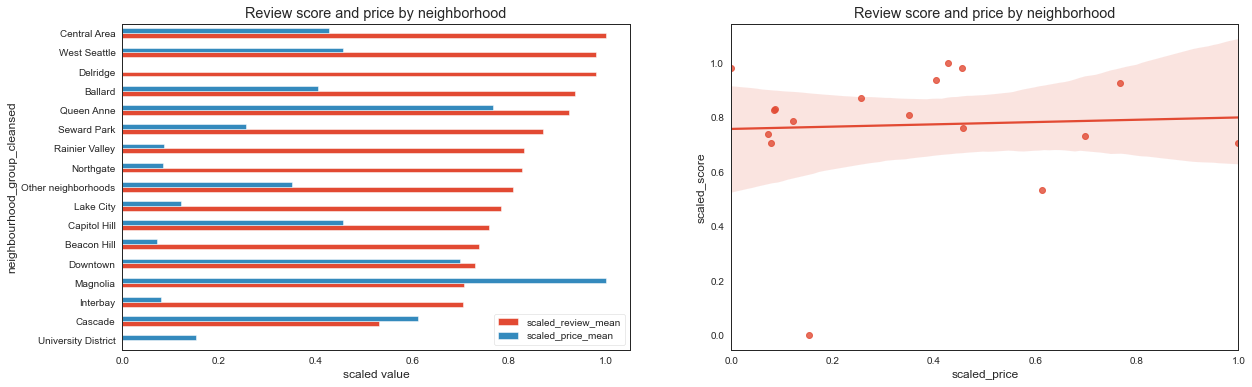

In [36]:
# introducing price to review by neighborhood
by_review_price = df_new.groupby('neighbourhood_group_cleansed')[['review_scores_rating', 'price']].mean()

# use scaler to normalize data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
new_by = scaler.fit_transform(by_review_price)

by_review_price[['scaled_review_mean', 'scaled_price_mean']] = new_by
by_review_price = by_review_price[['scaled_review_mean', 'scaled_price_mean']].sort_values(by='scaled_review_mean',
                                                                         ascending = True)
# visualize - set ax object
fig, axes = plt.subplots(1, 2, figsize = (20, 6))

# visualize - left
by_review_price.plot(kind = 'barh', ax = axes[0])
axes[0].set_title('Review score and price by neighborhood')
axes[0].set_xlabel('scaled value')

# visualize - right
sb.regplot(x = by_review_price['scaled_price_mean'], y = by_review_price['scaled_review_mean'], ax = axes[1])                                                               
axes[1].set_title('Review score and price by neighborhood')
axes[1].set_xlabel('scaled_price')
axes[1].set_ylabel('scaled_score');

> In left plot, review ratings have been sorted from high to low and price is listed aside. However, price doesn't seem to follow the same pattern of review rating. For instance, Central Area has the best rating, but the price is quite average among all neighborhoods. <br>
> The right plot showing a flat line with all points spreading, makes the assumption a bit more certain.

## 3. In which season most reviews are left?

In [37]:
# adjust data format in review dataset and extract month
df_rev['date'] = pd.to_datetime(df_rev['date'], yearfirst = True)
df_rev['month'] = df_rev['date'].dt.month

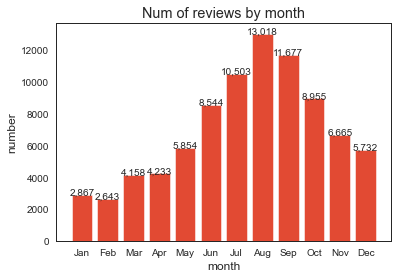

In [38]:
# data and labels preparation
cat_label = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
review_by_month = df_rev['month'].value_counts().sort_index()

# visualize
plt.bar(x = review_by_month.index, height = review_by_month.values)
plt.xticks(ticks = np.arange(1, 13), labels = cat_label)
plt.title('Num of reviews by month')
plt.xlabel('month')
plt.ylabel('number')

# annotate
for x in np.arange(0, 12):
    label = review_by_month.values[x]
    plt.text(x + 1, label, s = '{:,}'.format(label), ha = 'center')

> Most of reviews are left in summer and early autumn (Jul - Sep), which could also be the peak seasons of voacation. <br>
> The least is left in Feb and Jan.

## 4. What features are important to review of a listing?

### Categorical features preparation

In [54]:
# set a copy with id as index
new_copy = df_new.set_index('id')

In [55]:
# select categorical features
cat_features = new_copy.select_dtypes(include = ['object'])
cat_features.astype('str')

,host_response_time,host_is_superhost,host_identity_verified,neighbourhood_group_cleansed,property_type,room_type,instant_bookable,cancellation_policy
id,,,,,,,,
241032,within a few hours,f,t,Queen Anne,Apartment,Entire home/apt,f,moderate
953595,within an hour,t,t,Queen Anne,Apartment,Entire home/apt,f,strict
3308979,within a few hours,f,t,Queen Anne,House,Entire home/apt,f,strict
278830,within an hour,f,t,Queen Anne,House,Entire home/apt,f,strict
5956968,other,f,t,Queen Anne,House,Private room,f,strict
...,...,...,...,...,...,...,...,...
262764,within an hour,f,t,Other neighborhoods,House,Entire home/apt,f,strict
8578490,within a few hours,f,t,Other neighborhoods,Apartment,Entire home/apt,f,moderate
3383329,within an hour,t,t,Other neighborhoods,Apartment,Entire home/apt,t,moderate


In [56]:
# drop neighborhood column as it has been investigated
# cat_df = cat_features.drop('neighbourhood_group_cleansed', axis = 1);

In [57]:
# get dummy of all categorical features
cat_dummy = pd.get_dummies(cat_features)

In [58]:
# drop original cat features then merge dummies
drop_cat = new_copy.drop(cat_features.columns, axis = 1)
main_df = drop_cat.merge(cat_dummy, left_index = True, right_index = True)

In [59]:
main_df.reset_index(inplace = True)
main_df = main_df.drop('id', axis = 1)

### Numerical features

In [60]:
num_features = new_copy.select_dtypes(include = ['int64', 'float64'])
num_features.head()

,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,host_verifications_num,amentities_num,comments_len
id,,,,,,,,,,,,,,,,,,,,
241032,4,1.0,1.0,1.0,85.0,0.0,0.0,2,5.0,1,365,14,41,71,346,207,95.0,4,10,201
953595,4,1.0,1.0,1.0,150.0,100.0,40.0,1,0.0,2,90,13,13,16,291,43,96.0,6,16,343
3308979,11,4.5,5.0,7.0,975.0,1000.0,300.0,10,25.0,4,30,1,6,17,220,20,97.0,5,21,344
278830,6,2.0,3.0,3.0,450.0,700.0,125.0,6,15.0,1,1125,30,60,90,365,38,92.0,5,13,259
5956968,2,1.0,1.0,1.0,120.0,0.0,40.0,1,30.0,1,6,0,0,27,302,17,95.0,5,6,180


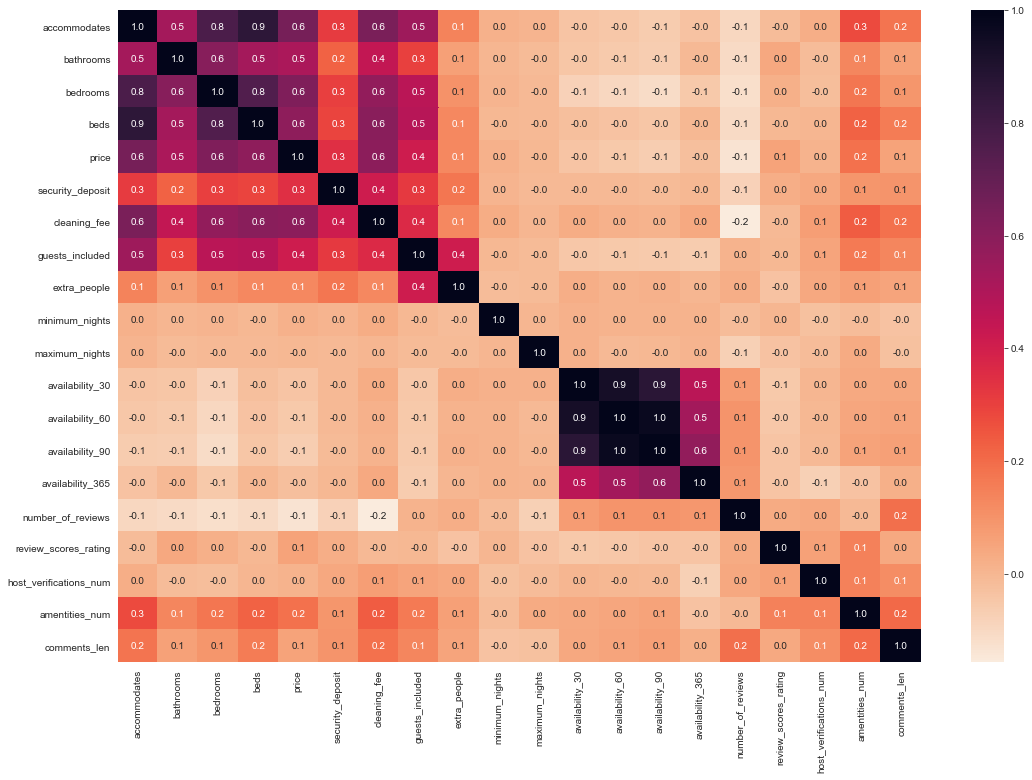

In [61]:
# plot to see if any similar features
plt.figure(figsize = (18, 12))
sb.heatmap(num_features.corr(), annot = True, fmt = '.1f', cmap = 'rocket_r');

> Here is quite some correlated features, creating noise to prediction model, but it doesn't impact feature importance. However, while correlated features exist, one feature shows up on list yet the importance of other correlated features will be traded off.

### Random Forest Regressor for feature importance

In [62]:
# prepare dataset
X = main_df.drop('review_scores_rating', axis = 1)
y = main_df['review_scores_rating']

In [63]:
# fit model
model = RandomForestRegressor()
model.fit(X, y)
importance = model.feature_importances_

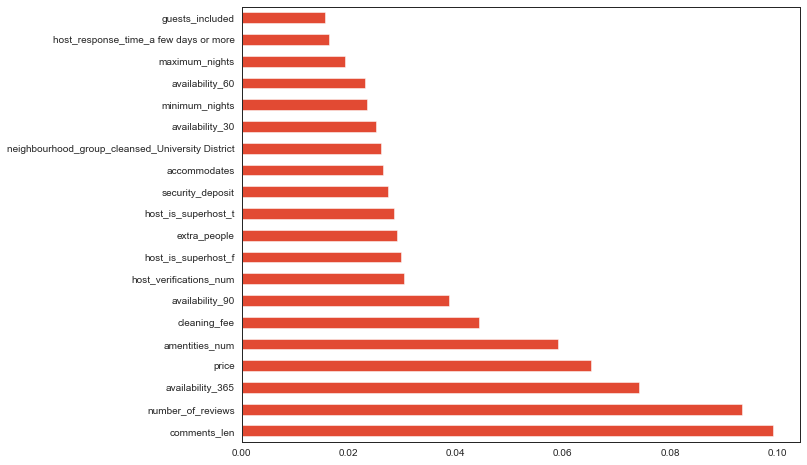

In [64]:
# visualize importance
df_importance = pd.Series(importance, index = X.columns)
df_importance.nlargest(20).plot(kind = 'barh', figsize = (10, 8));

Above we could find top 20 important features, in summary: comments_length, number of reviews, availability, price, number of amentities, cleaning_fee, superhost label, number of host verifications, extra people, security_deposit, accommodates, neighborhood, min and max nights, guests included and host response time. <br>
Some of them are related to positive results, the other can cause a reduction to review scores rating, which could be summarized as that some features are value adding, while some are necessities.

### Comment feature between good review and bad review
> Now we would like to split reviews in 3 groups - top 25%, bottom 25% and the other, by using wordcloud, we could see if there are any difference in keywords used in comments.

In [65]:
# prepare comments and review scores rating
new_rev = df_rev.merge(df_lst[['id', 'review_scores_rating']], how = 'left', left_on = 'listing_id', right_on = 'id')

# drop null rows in review_scores_rating
new_rev = new_rev.dropna(axis = 0, subset = ['review_scores_rating'])

In [66]:
# create group based on review_scores_rating
top_10 = np.percentile([new_rev['review_scores_rating'].values], 90)

bin_edges = [0, top_10, 100]
bin_names = ['bottom_90', 'top_10']
new_rev['rating_group'] = pd.cut(new_rev['review_scores_rating'], bin_edges, labels = bin_names)

In [67]:
new_rev['comments'] = new_rev['comments'].astype('str')

top_10_comments = ' '.join(new_rev[new_rev['rating_group'] == 'top_10']['comments']).lower()

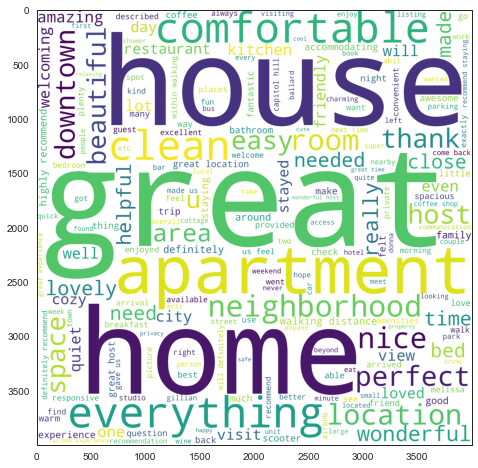

In [68]:
# customize some stopwords
seattle_stopwords = STOPWORDS.add('place')
seattle_stopwords = STOPWORDS.add('seattle')
seattle_stopwords = STOPWORDS.add('stay')

# prepare dataset
top10_wordcloud = WordCloud(stopwords = seattle_stopwords, background_color = 'white', height = 4000, width = 4000).generate(top_10_comments)

# show words
plt.figure(figsize = (16,8))
plt.imshow(top10_wordcloud)